In [6]:
from typing import Optional, Sequence, List, Dict, Any
from drn_interactions.transforms import SpikesHandler
from drn_interactions.io import load_derived_generic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# sns.set_theme(context="paper", style="ticks")

In [8]:
# load data


class SpikeTrainLoader:
    def __init__(
        self,
        session_name: str,
        duration: float = 5.0,
        max_neurons: Optional[int] = None,
        block="pre",
    ):
        self.session_name = session_name
        self.duration = duration
        self.block = block
        neurons = load_derived_generic("neuron_types.csv").loc[
            lambda x: x["session_name"] == session_name
        ]
        self.max_neurons = max_neurons
        self.neurons = neurons

    def get_trians_by_type(self, t_start) -> Dict[str, List[np.ndarray]]:
        types = self.neurons.neuron_type.unique()
        trains = {}
        for neuron_type in types:
            neurons = self.neurons.loc[lambda x: x["neuron_type"] == neuron_type][
                "neuron_id"
            ].values
            trains[neuron_type] = self.get_trains(t_start, ids=neurons)
        return trains

    def get_trains(self, t_start, ids: Optional[Sequence] = None) -> List[np.ndarray]:
        if ids is None:
            ids = self.neurons["neuron_id"].values

        sh = SpikesHandler(
            bin_width=1,
            session_names=[self.session_name],
            t_start=t_start,
            t_stop=t_start + self.duration,
            block=self.block,
        )
        df_spikes = sh.spikes.loc[lambda x: x["neuron_id"].isin(ids)]
        trains = [dfg["spiketimes"].values for _, dfg in df_spikes.groupby("neuron_id")]
        trains = trains[: self.max_neurons]
        return trains


def load_spikes(session_name):
    ...


def load_events(session_name):
    ...

In [9]:
# preprocess data

def get_trains(session_name):
    ...

In [10]:
# plot data


def make_grid(
    trains: Dict[Any, str],
    fig: Optional[plt.Figure] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order=None,
):
    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    n_rows = len(neuron_types)
    n_cols = 1
    height_ratios = np.array([len(trains[neuron_type]) for neuron_type in neuron_types])
    height_ratios = height_ratios / height_ratios.sum()
    gridspec_kw = gridspec_kw or {}
    gridspec_kw["height_ratios"] = height_ratios
    axes = fig.subplots(n_rows, n_cols, gridspec_kw=gridspec_kw)
    return axes
    

def plot_raster(trains: List[np.ndarray], ax=None, **eventplot_kwargs):
    ax = ax or plt.subplots()[1]
    ax.eventplot(
        trains,
        **eventplot_kwargs,
    )
    ax.axis("off")
    return ax


def plot_raster_grouped(
    trains: Dict[str, List[np.ndarray]],
    fig=None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    eventplot_kwargs = eventplot_kwargs or {}
    gridspec_kw = gridspec_kw or {}

    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    axes = make_grid(trains, fig=fig, gridspec_kw=gridspec_kw, type_order=neuron_types)

    for ax, neuron_type in zip(axes, neuron_types):
        train_list = trains[neuron_type]
        plot_raster(train_list, ax=ax, **eventplot_kwargs)
    return fig, axes

In [47]:
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.io import load_events
from drn_interactions.plots.pallets_cmaps import PAL_GREY_BLACK

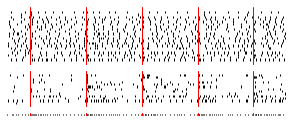

In [45]:
# Set params

df_events =  load_events("base_shock")
neurons = load_derived_generic("neuron_types.csv")

SESSIONS = ExperimentInfo.foot_shock_sessions_10min

# SESSION = SESSIONS[4]
SESSION = "hamilton_37"
T_START = 12
DURATION = 10
T_STOP = T_START + DURATION
MAX_NEURONS = None
FIGSIZE = (5, 2)
eventplot_kwargs = dict(
    color="black",
    linewidths=1,
    linelengths=1,
)

####

train_loader = SpikeTrainLoader(
    SESSION, 
    duration=DURATION, 
    max_neurons=MAX_NEURONS,
    block="base_shock"
    )
trains = train_loader.get_trians_by_type(t_start=T_START)


f = plt.figure(figsize=FIGSIZE)
plot_raster_grouped(trains, fig=f, eventplot_kwargs=eventplot_kwargs)

events = (
    df_events
    .loc
    [lambda x: 
    (x["session_name"] == SESSION) & 
    (x["event_s"] >= T_START) & 
    (x["event_s"] <= T_STOP)
    ].event_s.values
)


for ax in f.axes:
    ax.set_xlim(T_START, T_STOP)
    for event in events:
        ax.axvline(event, color="red", linewidth=1, linestyle="-")


f.savefig(Config.fig_dir / "psth raster.png", dpi=300, bbox_inches="tight")

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


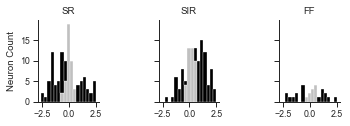

In [63]:
df_effects = load_derived_generic("fast_fs_foot_shock_unit_responders.csv").merge(neurons)

g = sns.FacetGrid(
    df_effects, 
    col="neuron_type",  
    sharey=True,  
    sharex=True, 
    height=1.5, 
    aspect=1.2, 
    gridspec_kws=dict(wspace=1),
    col_order=["SR", "SIR", "FF"]
    )

g.map_dataframe(
    sns.histplot, 
    x="Diff", 
    color="black", 
    hue="sig",
    palette=PAL_GREY_BLACK,
    multiple="stack",
    alpha=1,
    hue_order=[True, False],
    bins=np.arange(-2.6, 2.6, 0.3),
    
    )

g.set_titles("{col_name}")
g.set_ylabels("Neuron Count")
# g.set_xlabels("Post Shock Rate Change\n(Z) (0-200ms)")
g.set_xlabels("")
g.figure.align_ylabels()
g.savefig(Config.fig_dir / "fs_fast_hists.png", dpi=300, bbox_inches="tight")